# Climate Analysis

In [1]:
import datetime as dt
from datetime import datetime
import matplotlib
from matplotlib import style
style.use('seaborn')
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

### Opening DB and reflecting tables to classes

In [2]:
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [3]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()


['measurement', 'station']

In [4]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [5]:
session = Session(engine)

## Precipitation Analysis

### Filter for last 12 months of data

In [6]:
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [7]:
prcp_results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > '2016-08-23').order_by(Measurement.date).all()

In [8]:
prcp_df = pd.DataFrame(prcp_results, columns=['date', 'prcp'])
prcp_df.set_index('date', inplace=True, drop=True )
prcp_df.head(10)

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,1.45
2016-08-25,0.08
2016-08-25,0.08
2016-08-25,0.00


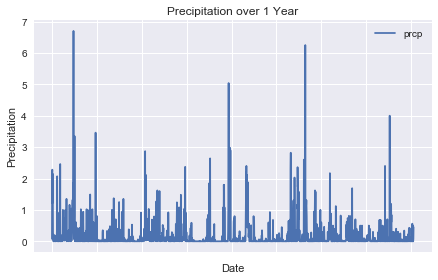

In [9]:
prcp_df.plot(title='Precipitation over 1 Year')
plt.tight_layout()
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.xticks(rotation=45)
plt.show()


### Station Count

In [10]:
session.query(func.count(Station.station)).all()


[(9)]

### Observation Count by Station

In [11]:
tobs_results = session.query(Measurement.station, Measurement.tobs, (func.count(Measurement.tobs).label('total'))).\
filter(Measurement.date > '2016-08-23').group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

tobs_results

[('USC00519397', 81, 358),
 ('USC00519281', 79, 351),
 ('USC00513117', 77, 342),
 ('USC00516128', 76, 327),
 ('USC00519523', 82, 313),
 ('USC00514830', 82, 264),
 ('USC00517948', 80, 60)]

In [12]:
tobs_df = pd.DataFrame(tobs_results, columns=['station','tobs','total'])
tobs_df.set_index('station', inplace=True, drop=True )
tobs_df.head(10)

,tobs,total
station,,
USC00519397,81,358
USC00519281,79,351
USC00513117,77,342
USC00516128,76,327
USC00519523,82,313
USC00514830,82,264
USC00517948,80,60


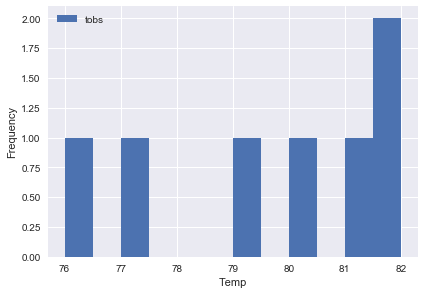

In [13]:
tobs_df.plot.hist(y='tobs', bins=12)
plt.tight_layout()
plt.xlabel('Temp')
plt.show()

### Functions for Temps

In [14]:
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [15]:
calc_temps('2016-08-22', '2016-08-29')

[(71, 78.06382978723404, 84)]

In [16]:
# This function uses calc_temps to privide temps from prior year
def trip_temps(trip_start, trip_end):
    year_prior = dt.timedelta(days=365)
    start = datetime.strptime(trip_start, '%Y-%m-%d')- year_prior
    end = datetime.strptime(trip_end, '%Y-%m-%d')- year_prior
    return(calc_temps(start, end))


In [19]:
trip_temps('2018-08-15', '2018-08-22')

[(71, 78.18181818181819, 83)]

In [17]:
temp_stats = (trip_temps('2018-08-15', '2018-08-22'))

(0, 90)

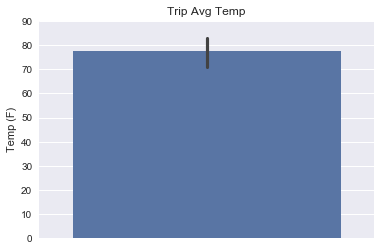

In [22]:
sns.barplot(temp_stats, orient='v')
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.ylim(0,90)